In [1]:
from PIL import Image, ImageDraw, ImageFont
import requests
from datetime import date
from collections import Counter

# Function

In [2]:
def GetData(username, session):

    return_data = [username]
    response = session.get("https://api.github.com/users/"+username)
    
    if response.ok:
        follower_count = response.json()["followers"]
        if follower_count > 999:
            follower_count = str(round(follower_count / 1000, 2)) + "k"
        else:
            follower_count = str(follower_count)
        return_data.append(follower_count)
    else:
        print("error! can't get profile data", response.status_code)

    response = session.get("https://api.github.com/users/"+username+"/repos?per_page=100&sort=updated")
    
    if response.ok:
        total_stars = 0
        all_languages_urls = []
        
        for repo_data in response.json():
            all_languages_urls.append(repo_data["languages_url"])
            total_stars += repo_data["stargazers_count"]
            
        if total_stars > 999:
            total_stars = str(round(total_stars / 1000, 2)) + "k"
        else:
            total_stars = str(total_stars)
            
        all_language_data = []
        language_counter = Counter()
        
        for language_url in all_languages_urls:
            response = session.get(language_url)
            if response.ok:
                all_language_data.append(response.json())
            else:
                print("error! can't get language data", language_url, response.status_code)
            
        for language in all_language_data:
            language_counter.update(language)
        
        language_counter = dict(language_counter)
        
        total_language_amount = sum(language_counter.values())
        
        language_percentage = {}
        for key, val in language_counter.items():
            pct = val * 100.0 / total_language_amount
            pct = round(pct, 2)
            language_percentage[key] = pct
        
        sorted_language_by_percentage = sorted(language_percentage.items(), key=lambda item: item[1])
        sorted_language_by_percentage = sorted_language_by_percentage[::-1]
        
        return_data.append(total_stars)
        return_data.append(sorted_language_by_percentage)
    else:
        print("error! can't get repo data", response.status_code)

    return return_data

In [3]:
col = {
	"black":"#171421",
	"red":"#C01C28",
	"green":"#26A269",
	"brown":"#A2734C",
	"darkblue":"#12488B",
	"darkpurple":"#A347BA",
	"cyan":"#2AA1B3",
	"lightgrey":"#D0CFCC",
	"grey":"#5E5C64",
	"lightred":"#F66151",
	"lightgreen":"#33D17A",
	"yellow":"#E9AD0C",
	"blue":"#2A7BDE",
	"purple":"#C061CB",
	"skyblue":"#33C7DE",
	"white":"#FFFFFF"
}

In [4]:
def CreateCard(data, pc_name = "gh", color_dict = col, main_color = "cyan", terminal_opacity = 255, max_show_language = 5):
    
    username, follower_count, total_stars, sorted_language_by_percentage = data

    lines = [username+"@"+pc_name,
             "-"*len(username+"@"+pc_name),
             "followers: "+follower_count,
             "total stars: "+total_stars
            ]

    for key, val in sorted_language_by_percentage:
        max_show_language -= 1
        if max_show_language >= 0:
            lines.append(key+": "+str(val))

    lines.append("updated: "+str(date.today()))

    base = Image.new("RGBA",(440,320))    
    draw = ImageDraw.Draw(base)
    
    terminal_shape = [(0, 0), (440, 320)] 
    terminal_rgba = list(int(color_dict["black"].lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    terminal_rgba.append(terminal_opacity)
    terminal_rgba = tuple(terminal_rgba)
    draw.rectangle(terminal_shape, fill = terminal_rgba, outline = color_dict["grey"]) 
    
    default = ImageFont.load_default()

    x = 220
    old_x = x
    y = 20
    old_y = y
    for line in lines:
        draw.text((x, y), line, color_dict["white"], font=default)
        y += 20
    
    shape_list = []
    
    for i in range(2):
        for i in range(8):
            shape_list.append([x, y, x + 15, y + 12])
            x += 17
        y += 17
        x = x - 1 - 15*9
        
    for color in col:
        draw.rectangle(shape_list.pop(0), fill=color_dict[color]) 

    draw.text((20, y+20), username+"@"+pc_name+": _", color_dict["white"], font=default)
    draw.text((20, y+20), username+" "+pc_name, col[main_color], font=default)
    
    x = old_x
    y = old_y
    for line in lines:
        draw.text((x, y), line.replace("@", " ").replace("-", "").split(":")[0], color_dict[main_color], font=default)
        y += 20
    
    return base

In [5]:
def AddBackgroundAndForeground(bg, fg, card):
    bg = bg.resize((450, 330))
    bg.paste(card, (5, 5), card)
    fg = fg.resize((205, 205))
    bg.paste(fg, (7, 7), fg)
    return bg

# Main

In [6]:
session = requests.Session()
try:
    with open ("token.txt", "r") as f:
        x = f.readline()
    session.headers.update({"Authorization": "token "+x.strip()})
except:
    pass
    
username = "kritserv"
dat = GetData(username, session)

In [7]:
background = Image.open('wallpaper.jpg')
top_image = Image.open('octocat.png')

In [8]:
card = CreateCard(data = dat, pc_name = "GitHub", color_dict = col, main_color = "cyan", terminal_opacity = 225)

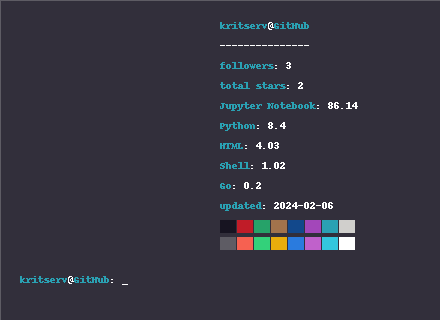

In [9]:
card

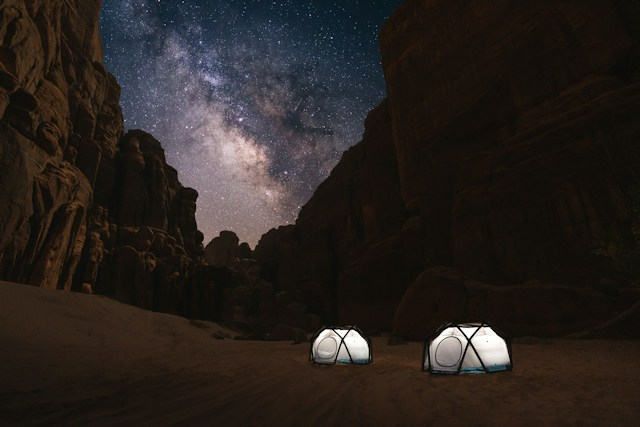

In [10]:
background

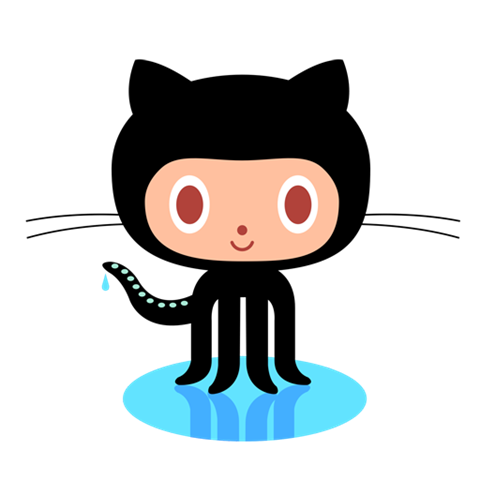

In [11]:
top_image

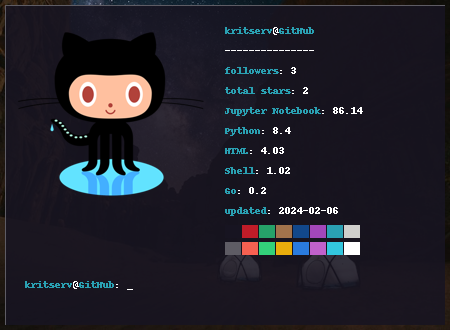

In [12]:
new_card = AddBackgroundAndForeground(background, top_image, card)
new_card

In [13]:
new_card.save("githubstat_card.png")